Your dataset columns are: ['Unnamed: 0', 'timestamp', 'ele_0', 'ele_1', 'ele_2', 'ele_3', 'ele_4', 'ele_5', 'ele_6', 'ele_7', 'ele_8', 'ele_9', 'ele_10', 'ele_11', 'ele_12', 'ele_13', 'ele_14', 'ele_15', 'ele_16', 'ele_17', 'ele_18', 'ele_19', 'ele_20', 'ele_21', 'ele_22', 'ele_23', 'ele_24', 'ele_25', 'ele_26', 'ele_27', 'ele_28', 'ele_29', 'ele_30', 'ele_31', 'ele_32', 'ele_33', 'ele_34', 'ele_35', 'ele_36', 'ele_37', 'Fx', 'Fy', 'Fz', 'Fx_norm', 'Fy_norm', 'Fz_norm']
Successfully scaled data using columns: ['Unnamed: 0', 'timestamp', 'ele_0', 'ele_1', 'ele_2', 'ele_3', 'ele_4', 'ele_5', 'ele_6', 'ele_7', 'ele_8', 'ele_9', 'ele_10', 'ele_11', 'ele_12', 'ele_13', 'ele_14', 'ele_15', 'ele_16', 'ele_17', 'ele_18', 'ele_19', 'ele_20', 'ele_21', 'ele_22', 'ele_23', 'ele_24', 'ele_25', 'ele_26', 'ele_27', 'ele_28', 'ele_29', 'ele_30', 'ele_31', 'ele_32', 'ele_33', 'ele_34', 'ele_35', 'ele_36', 'ele_37', 'Fx_norm', 'Fy_norm', 'Fz_norm']
Training with IMU + Pressure data...
Epoch 1/100
730/7

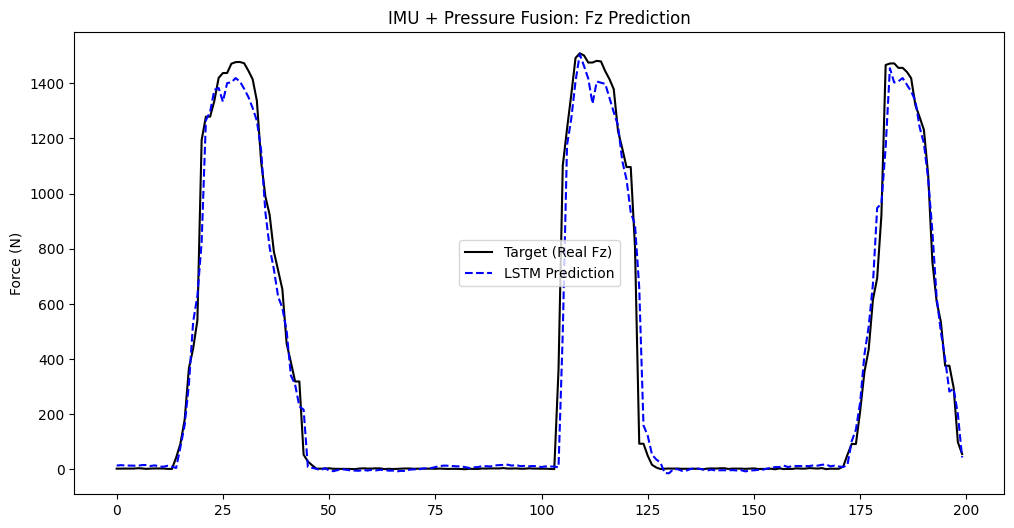

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- STEP 1: FIXING THE COLUMN NAMES ---
# First, let's see what your columns are actually named
print("Your dataset columns are:", df.columns.tolist())

# EDIT THESE TWO LINES to match what you see in the printout above!
# If your columns are 'Ax', 'Ay', use those. If they are 'sensor1', 'sensor2', use those.
input_cols = [col for col in df.columns if col not in ['Fx', 'Fy', 'Fz', 'target', 'time']]
output_cols = ['Fx', 'Fy', 'Fz']

# Verify the columns exist before scaling
missing_cols = [c for c in input_cols if c not in df.columns]
if missing_cols:
    print(f"Error: These columns were not found: {missing_cols}")
    print("Please check your spelling or capitalization (e.g., 'Accel_X' vs 'accel_x')")
else:
    # --- STEP 2: LOAD AND SCALE DATA ---
    scaler_in = MinMaxScaler(feature_range=(0, 1))
    scaler_out = MinMaxScaler(feature_range=(0, 1))

    scaled_input = scaler_in.fit_transform(df[input_cols].values)
    scaled_output = scaler_out.fit_transform(df[output_cols].values)

    print("Successfully scaled data using columns:", input_cols)

# --- STEP 3: DEFINE THE MODEL ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True), # Increased units for more complex IMU data
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(output_cols))
])

model.compile(optimizer='adam', loss='mse')

# --- STEP 4: TRAIN WITH EARLY STOPPING ---
# Set to 100 epochs. It will stop when it reaches the best accuracy.
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

print("Training with IMU + Pressure data...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# --- STEP 5: PREDICT AND REVERT SCALING ---
predictions_scaled = model.predict(X_test)
# Use the OUTPUT scaler to get Newtons back
predictions = scaler_out.inverse_transform(predictions_scaled)
y_actual = scaler_out.inverse_transform(y_test)

# --- STEP 6: CALCULATE ACCURACY (R2) ---
r2_fz = r2_score(y_actual[:, 2], predictions[:, 2])
print(f"\nTarget Axis (Fz) R2 Score: {r2_fz:.4f}")

# --- STEP 7: PLOT THE NEW RESULT ---
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:200, 2], color='black', label='Target (Real Fz)')
plt.plot(predictions[:200, 2], color='blue', linestyle='--', label='LSTM Prediction')
plt.title('IMU + Pressure Fusion: Fz Prediction')
plt.ylabel('Force (N)')
plt.legend()
plt.show()